In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS exclusion curve

In [2]:
cmsData = pd.read_pickle('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/DMsimp_spin-0_Monojet_DF.pcl')
cmsCurve = np.genfromtxt('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/HEPData-ins1894408-v2-csv/Signalstrengthlimits,scalarmediator.csv',
                        skip_header=14,names=True,delimiter=',',skip_footer=60)

### Load Recast Data

In [3]:
recastData = pd.read_pickle('../CMS-EXO-20-004/scanResults_scalar_cms_nocut.pcl')

### Get all model points

In [4]:
models = []
mCols = ['Coupling','Mode','$m_{med}$','$m_{DM}$','$g_{DM}$', '$g_{q}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
print('%i models loaded' %len(models))

25 models loaded


### Get model parameters

In [5]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': 'Scalar', 'Mode': 'DM+QCDjets', '$m_{med}$': [800.0, 450.0, 100.0, 200.0, 10.0, 300.0, 400.0, 50.0, 500.0, 600.0, 700.0, 350.0], '$m_{DM}$': [1.0, 225.0, 4.0, 6.0, 40.0, 200.0, 45.0, 50.0, 275.0, 20.0, 22.0, 55.0, 150.0, 28.0], '$g_{DM}$': 1.0, '$g_{q}$': 1.0}
Coupling = Scalar
Mode = DM+QCDjets
$g_{DM}$ = 1.0
$g_{q}$ = 1.0


In [6]:
# Remove duplicated data from other datasets
recastData = recastData[recastData['Data-takingperiod'] == 2017]
cmsData = cmsData[cmsData['Data-takingperiod'] == 2017]

### Get all model points with common models to CMS data

In [7]:
keys = list(cmsData[mCols].columns.values)
i1 = recastData.set_index(keys).index
i2 = cmsData.set_index(keys).index
recastData = recastData[i1.isin(i2)]
cmsData = cmsData[i2.isin(i1)]
print(len(recastData),len(cmsData))

25 25


In [8]:
recastData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)  
cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)                

### Add ratio of upper limits for the common points

In [9]:
kfactor = 0.85
recastData['UL ratio'] = (recastData['$\mu^{UL}_{obs}$']/kfactor)/cmsData['$\mu^{UL}_{obs}$']

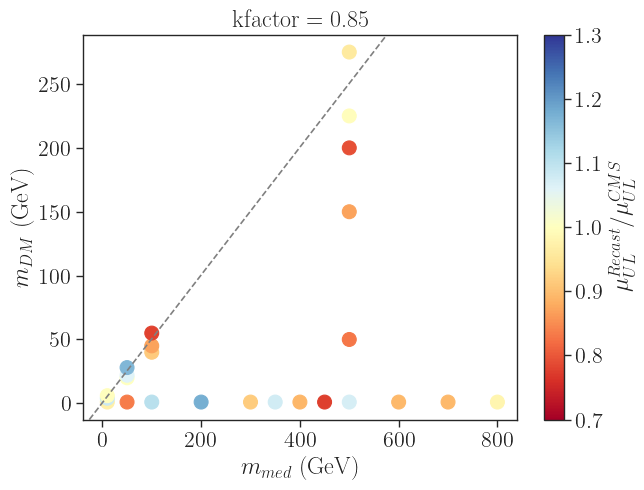

In [10]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=recastData['$m_{med}$'],y=recastData['$m_{DM}$'],vmin=0.7,vmax=1.3,
            c=recastData['UL ratio'],cmap=plt.cm.get_cmap('RdYlBu'),s=100)
cbar = plt.colorbar(label=r'$\mu^{Recast}_{UL}/\mu^{CMS}_{UL}$')
plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

# cbar.set_ticks([0.5,0.75,0.9,1.0,1.1,1.25,1.5])

plt.xlabel(r'$m_{med}$ (GeV)')
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
# plt.yscale('log')
plt.title('kfactor = %1.2f' %kfactor)
plt.show()

### Get all model points with mDM = 1 GeV

In [11]:
recastData = recastData[(recastData['$m_{DM}$'] == 1.0)]
cmsData = cmsData[(cmsData['$m_{DM}$'] == 1.0)]

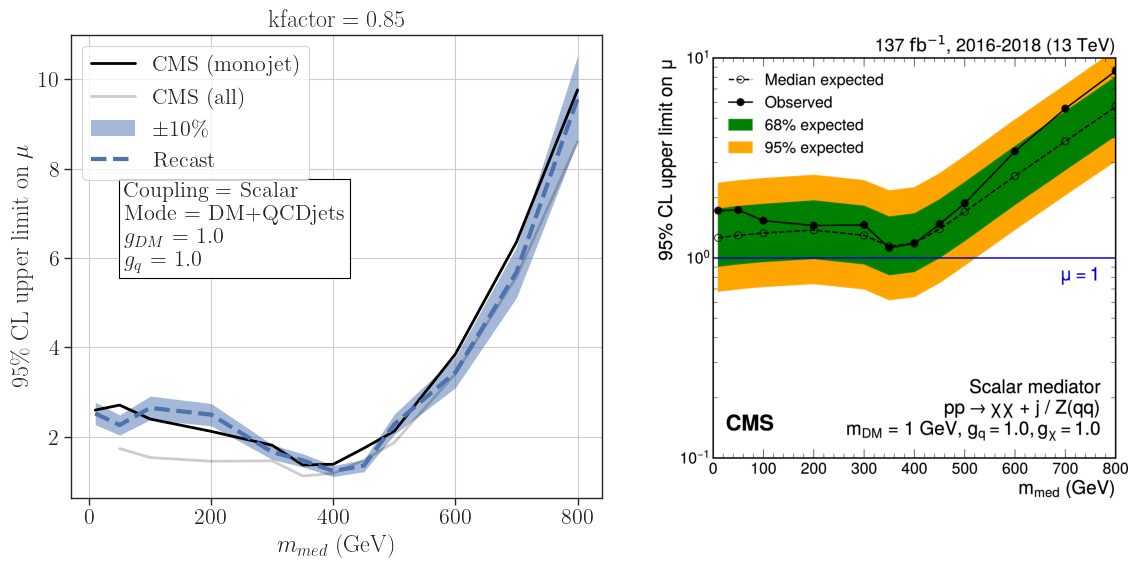

In [12]:
fig,ax = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
ax[0].plot(cmsData['$m_{med}$'],cmsData['$\mu^{UL}_{obs}$'],label='CMS (monojet)',linewidth=2,color='black')

ax[0].plot(cmsCurve['m_med_GeV'],cmsCurve['Signal_strength_limit'],label='CMS (all)',
         linewidth=2,color='black',alpha=0.2)

ax[0].fill_between(recastData['$m_{med}$'],1.1*recastData['$\mu^{UL}_{obs}$']/kfactor,
                 0.9*recastData['$\mu^{UL}_{obs}$']/kfactor,
                alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax[0].plot(recastData['$m_{med}$'],recastData['$\mu^{UL}_{obs}$']/kfactor,
         linestyle='--',label='Recast',linewidth=3,markersize=7)
    

# plt.hlines(y=1.0,xmin=modelData['$m_{med}$'].min(),xmax=modelData['$m_{med}$'].max(),color='blue')
ax[0].set_xlabel(r'$m_{med}$ (GeV)')
ax[0].set_ylabel(r'95\% CL upper limit on $\mu$')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
ax[0].set_title('kfactor = %1.2f' %kfactor)
ax[0].text(0.1,0.5,textstr,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = ax[0].transAxes)
ax[0].legend()
ax[0].grid()

cmsPlot = plt.imread('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/CMS-EXO-20-004_Figure_009-a.png')
ax[1].imshow(cmsPlot)
ax[1].axis('off')

plt.tight_layout()
plt.show()

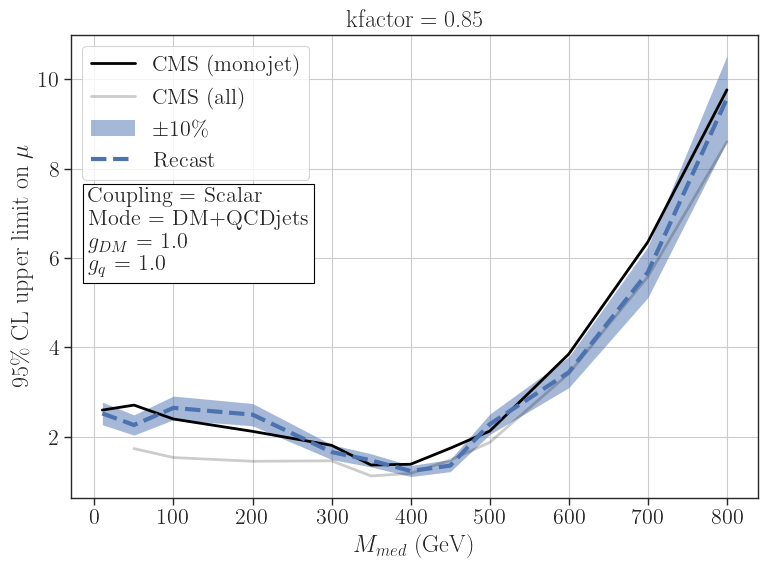

In [13]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(cmsData['$m_{med}$'],cmsData['$\mu^{UL}_{obs}$'],label='CMS (monojet)',linewidth=2,color='black')

ax.plot(cmsCurve['m_med_GeV'],cmsCurve['Signal_strength_limit'],label='CMS (all)',
         linewidth=2,color='black',alpha=0.2)

ax.fill_between(recastData['$m_{med}$'],1.1*recastData['$\mu^{UL}_{obs}$']/kfactor,
                 0.9*recastData['$\mu^{UL}_{obs}$']/kfactor,
                alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax.plot(recastData['$m_{med}$'],recastData['$\mu^{UL}_{obs}$']/kfactor,
         linestyle='--',label='Recast',linewidth=3,markersize=7)
    

# plt.hlines(y=1.0,xmin=modelData['$m_{med}$'].min(),xmax=modelData['$m_{med}$'].max(),color='blue')
ax.set_xlabel(r'$M_{med}$ (GeV)')
ax.set_ylabel(r'95\% CL upper limit on $\mu$')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
ax.set_title('kfactor = %1.2f' %kfactor)
ax.text(0.025,0.49,textstr,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = ax.transAxes)
ax.legend()
ax.grid()

plt.savefig('cms_exo_20_004_scalar.png')
plt.tight_layout()
plt.show()

In [14]:
cutflowRecast = recastData[['$m_{DM}$', '$m_{med}$', 'Fullsample', 'Triggeremulation', '$p_{T}^{miss}>250$GeV', 
                            'Electronveto', 'Muonveto', 'Tauveto', 'Bjetveto', 'Photonveto', '$\\Delta \\phi (jet,p_{T}^{miss})>0.5$ rad',
                            'LeadingAK4jet$p_{T}>100$GeV', 'LeadingAK4jet$\\eta<2.4$', 'HCALmitigation(jets)', 
                            'HCALmitigation($\\phi^{miss}$)']]
cutflowCMS = cmsData[['$m_{DM}$', '$m_{med}$', 'Fullsample', 'Triggeremulation', '$p_{T}^{miss}>250$GeV', 
                      '$p_{T}^{miss}$qualityfilters', 'Electronveto', 'Muonveto', 'Tauveto', 'Bjetveto', 
                      'Photonveto', '$\\Delta \\phi (jet,p_{T}^{miss})>0.5$ rad', '$\\Delta p_{T}^{miss}$ (PF-Cal)$<0.5$ rad', 'LeadingAK4jet$p_{T}>100$GeV', 
                      'LeadingAK4jet$\\eta<2.4$', 'LeadingAK4jetenergyfractions', 'Mono-Voverlapremoval', 
                      'HCALmitigation(jets)', 'HCALmitigation($\\phi^{miss}$)', 
                      '$\\Delta \\phi (\\mathrm{PF}_\\mathrm{Charged})<2.0$ rad']]

In [15]:
modelFilter = {'$m_{med}$' : 800.0, '$m_{DM}$' : 1.0}

In [16]:
cutflow = pd.concat((cutflowCMS,cutflowRecast))
cutflow = cutflow.loc[(cutflow[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]

In [17]:
relDiff = {}
for c in cutflow.columns:
    xList = cutflow[c].tolist()
    if all(isinstance(x,float) for x in xList):
        if xList[1]:
            relDiff.update({c : [np.abs(xList[0] - xList[1])/xList[0]]})
        else:
            relDiff.update({c : [np.nan]})
diff = pd.DataFrame.from_dict(relDiff)
diff.T

,0
$m_{DM}$,0.000000
$m_{med}$,0.000000
Fullsample,0.000000
Triggeremulation,0.173358
$p_{T}^{miss}>250$GeV,0.002531
$p_{T}^{miss}$qualityfilters,NaN
Electronveto,0.002445
Muonveto,0.005371
Tauveto,0.001920
Bjetveto,0.157192


In [18]:
recastData

,Coupling,Mode,$m_{med}$,$m_{DM}$,Data-takingperiod,Luminosity (1/fb),bin_250.0_280.0,bin_250.0_280.0_ErrorPlus,bin_250.0_280.0_ErrorMinus,bin_280.0_310.0,...,Bjetveto,Photonveto,"$\Delta \phi (jet,p_{T}^{miss})>0.5$ rad",LeadingAK4jet$p_{T}>100$GeV,LeadingAK4jet$\eta<2.4$,HCALmitigation(jets),HCALmitigation($\phi^{miss}$),$\mu^{UL}_{obs}$,$\mu^{UL}_{exp}$,UL ratio
0,Scalar,DM+QCDjets,10.0,1.0,2017,41.5,1746.189034,72.307896,72.307896,1037.519622,...,0.055393,0.055066,0.054288,0.051392,0.051392,0.051392,0.051392,2.145071,1.283860,0.971098
3,Scalar,DM+QCDjets,50.0,1.0,2017,41.5,1582.664418,61.915670,61.915670,985.517392,...,0.060123,0.059728,0.058927,0.056548,0.056548,0.056548,0.056548,1.924969,1.388242,0.835561
7,Scalar,DM+QCDjets,100.0,1.0,2017,41.5,1460.852590,62.951756,62.951756,997.801295,...,0.073356,0.072979,0.072040,0.069256,0.069256,0.069256,0.069256,2.250777,1.420552,1.104075
11,Scalar,DM+QCDjets,200.0,1.0,2017,41.5,1145.314828,50.102835,50.102835,813.334577,...,0.107098,0.106549,0.105040,0.100871,0.100871,0.100871,0.100871,2.122099,1.439213,1.176361
12,Scalar,DM+QCDjets,300.0,1.0,2017,41.5,1070.240729,52.402535,52.402535,722.233286,...,0.151034,0.150212,0.148615,0.142001,0.142001,0.142001,0.142001,1.409991,1.243067,0.916391
13,Scalar,DM+QCDjets,350.0,1.0,2017,41.5,1045.249490,54.891536,54.891536,737.690710,...,0.154238,0.153327,0.151299,0.145824,0.145824,0.145824,0.145824,1.252186,1.096630,1.076545
14,Scalar,DM+QCDjets,400.0,1.0,2017,41.5,975.256249,46.761917,46.761917,697.728837,...,0.170523,0.169229,0.167996,0.161654,0.161654,0.161654,0.161654,1.049635,0.955396,0.890623
15,Scalar,DM+QCDjets,450.0,1.0,2017,41.5,681.081129,39.167695,39.167695,535.424671,...,0.202352,0.200963,0.199195,0.191141,0.191141,0.191141,0.191141,1.152360,1.126226,0.776890
16,Scalar,DM+QCDjets,500.0,1.0,2017,41.5,435.219856,22.707191,22.707191,319.523720,...,0.206921,0.205574,0.203838,0.199587,0.199587,0.199587,0.199587,1.939574,1.559050,1.072050
22,Scalar,DM+QCDjets,600.0,1.0,2017,41.5,179.872199,11.027788,11.027788,140.301904,...,0.240135,0.238562,0.236045,0.226115,0.226115,0.226115,0.226115,2.928631,2.274877,0.893915


In [19]:
sigmaRatio = cmsData['Total xsec-pT150 (pb)']/recastData['Total xsec-pT150 (pb)']

In [20]:
sigmaRatio

0     0.895725
3     0.895490
7     0.901103
11    0.883627
12    0.880779
13    0.878507
14    0.800647
15    0.808083
16    0.884040
22    0.873784
23    0.879480
24    0.887137
Name: Total xsec-pT150 (pb), dtype: float64